In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

In [2]:
tauraat = pd.read_csv('./data/tau_pos_dis.csv', converters={'site_no': str}, low_memory=False)

In [3]:
tau_pos_freq = tauraat['site_no'].value_counts()

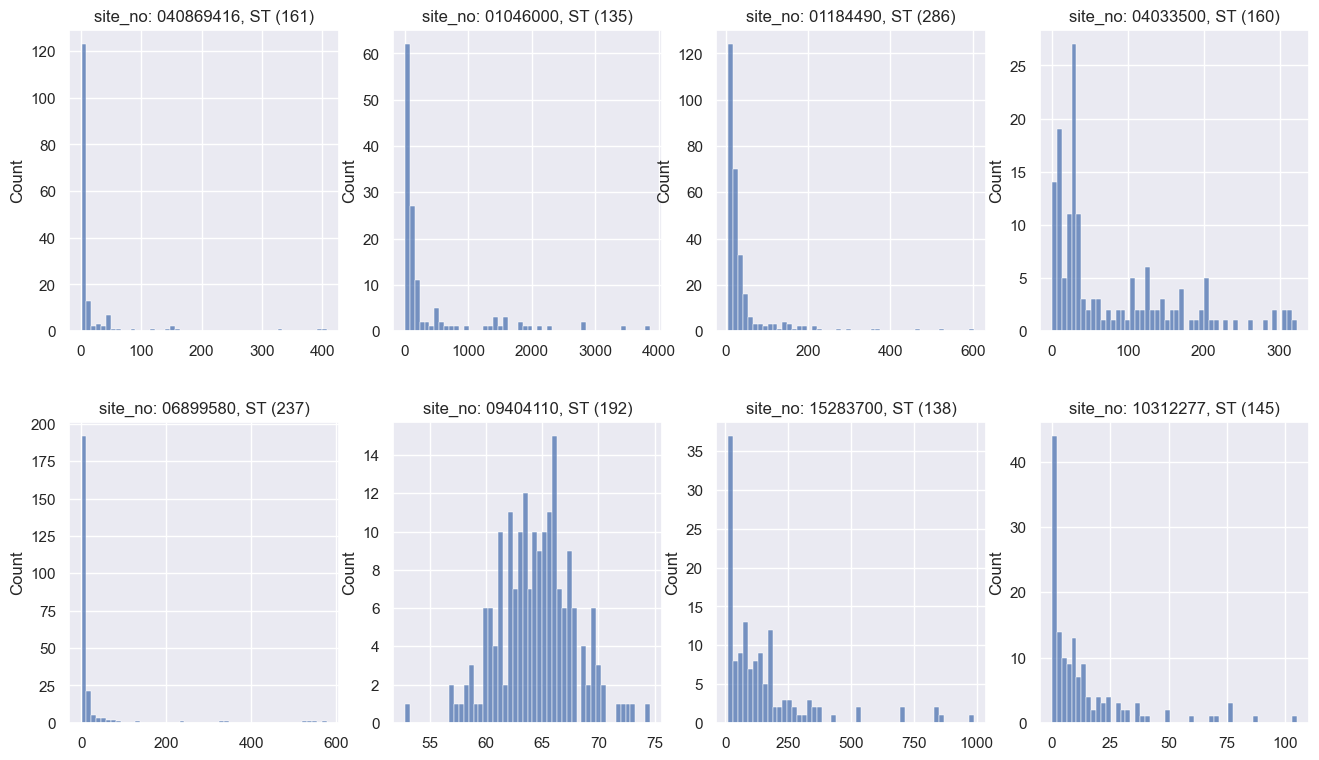

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=4 , figsize=(16, 9), constrained_layout=False)

random_sites = np.random.randint(0, 7098, 8).tolist()
for idx, site_obs in enumerate(tau_pos_freq.iloc[random_sites]):
    usgs_cd = tau_pos_freq.index[tau_pos_freq == site_obs].values[0]
    usgs_nm = tauraat[tauraat['site_no'] == usgs_cd].iloc[0]['station_nm']
    usgs_tp = tauraat[tauraat['site_no'] == usgs_cd].iloc[0]['site_tp_cd']

    i, j = divmod(idx, 4)
    df_plt = tauraat[tauraat["site_no"] == usgs_cd]

    # sns.histplot(x=df_plt['chan_width'], bins=50, ax=axes[i, j])
    sns.histplot(x=df_plt['discharge_va'], bins=50, ax=axes[i, j])
    axes[i, j].set_title(f"site_no: {usgs_cd}, {usgs_tp} ({site_obs})")
    axes[i, j].set_xlabel('')

plt.savefig('./data/tau_discharge_dist.png')
plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()